<h1><center>SI 370 Final Project<br />San Francisco Crime Classification & 
    Visualization</center></h1>
<center>McCoy Doherty, Hailey Harris, Evan Hogan,<br />Joleen Powers, & Jeong-Woo Ko</center>
<center>26 November 2019</center>

<h1>Purpose Statement</h1>
Technology is continually changing how law enforcement agencies strategize to combat crime.<br><br>

Organizations like the FBI and the Department of Homeland Security use machine learning algorithms to classify and even predict crimes.<br><br>

After a crime occurs, leads and evidence are sometimes lacking. Everything from subject description to time of day helps law enforcement agencies predict what happened and what can happen next.<br><br>

In this Kaggle project, San Francisco Crime Classification, we utilize machine learning techniques to classify and predict what category of crime (homicide, theft, etc.) took place given the location and time data corresponding with a given crime.

<h1>Imports and Setup</h1>

In [0]:
import numpy as np
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import warnings 
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('drive/Shared drives/SI370_KaggleDrive/assets/train.csv') 
test = pd.read_csv('drive/Shared drives/SI370_KaggleDrive/assets/test.csv')

<h1>Cleaning, Prep</h1>

Member functions to prepare data for classification. Adding metrics for time of year and time of day. Also added dummy bins for police department district that the crime occured in.

In [0]:
def handle_dates(df):
    df["Dates"] = pd.to_datetime(df["Dates"])
    df["Month"] = df["Dates"].dt.month
    df["Hour"] = df["Dates"].dt.hour
    return(df)

def add_seasons(df):
    df["isWinter"] = np.where(df.Month==12,1,np.where(
        df.Month==1,1,np.where(
            df.Month==2,1,0)))
    
    df["isSpring"] = np.where(df.Month==3,1,np.where(
        df.Month==4,1,np.where(
            df.Month==5,1,0)))    
    
    df["isSummer"] = np.where(df.Month==6,1,np.where(
        df.Month==7,1,np.where(
            df.Month==8,1,0)))   
    return(df)

def is_night(df):
    df["is_night"] = np.where(df.Dates.dt.hour == 22, 1, np.where(
    df.Dates.dt.hour == 23, 1, np.where(
    df.Dates.dt.hour == 24, 1, np.where(
    df.Dates.dt.hour == 0, 1, np.where(
    df.Dates.dt.hour == 1, 1, np.where(
    df.Dates.dt.hour == 2, 1, np.where(
    df.Dates.dt.hour == 3, 1, np.where(
    df.Dates.dt.hour == 4, 1, 0))))))))
    return(df)

def is_weekend(df):
    df["is_weekend"] = np.where(df.DayOfWeek == "Friday", 1, np.where(
    df.DayOfWeek == "Saturday", 1, np.where(
    df.DayOfWeek == "Sunday", 1, 0)))
    return(df)

def prepare_data(df):
    if("Descript" in df.columns):
        df = df.drop(labels=["Descript","Resolution","Address"], axis=1)

    df = handle_dates(df=df)
    df = add_seasons(df=df)
    df = is_night(df=df)
    df = is_weekend(df=df)
    df = pd.get_dummies(data=df, columns=["PdDistrict"])

    for dropper in ["Id","Address","Dates","DayOfWeek","Month","Hour"]:
        if(dropper in df.columns):
            df = df.drop(labels=dropper, axis=1)

    return(df)


<h1>Model Training</h1>
Test dataset is missing our main categorical feature, making it hard to work conventionally with the test dataset.<br>
Translation: We can predict category but have nothing to check our answers with.<br>
We'll need to use a train-test split derived from the training data.<br>

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train, test_size=0.3)

In [0]:
train_df = prepare_data(df=train_df)
test_df = prepare_data(df=test_df)

In [0]:
train_df.head(3)

,Category,X,Y,isWinter,isSpring,isSummer,is_night,is_weekend,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
742979,LARCENY/THEFT,-122.408231,37.787359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
503963,FRAUD,-122.365565,37.809671,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
424237,ASSAULT,-122.472879,37.745962,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
X_train = train_df.drop(labels=["Category"],axis=1)
y_train = train_df.Category
X_test = test_df.drop(labels=["Category"],axis=1)
y_test = test_df.Category

In [0]:
import sklearn.ensemble as skens
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')

In [0]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score
accuracy = rf_model.score(X_test, y_test)

In [0]:
accuracy

0.251644743086005

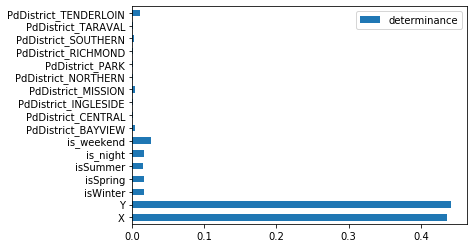

In [0]:
determinance = rf_model.feature_importances_
pd.DataFrame({"determinance":determinance}, index=list(X_train)).plot(kind="barh")

<h1>Model // HyperParameter Tuning</h1>

Using gridsearch, we passed in a dictionary of experimental parameters to obtain reasonable 'ballpark" estimates for improved parameters

In [0]:
from sklearn.model_selection import GridSearchCV
paramaters = {'n_estimators': [25, 30, 35, 40], 'max_depth': [1, 5, 10, 15, 20], 'min_samples_split' : [8, 9, 10]}

In [0]:
train = prepare_data(df=train)

In [0]:
grid = GridSearchCV(rf_model, paramaters, cv=10)
grid.fit(train.drop(columns=["Category"],axis=1),train["Category"])

# takes 30+ min to run. Only ran these steps once to avoid useless waiting. 

In [0]:
grid.best_estimator_
# get best model setup for tuning


In [0]:
grid.best_params_
# get best parameter to plug into the ideal model above

<h1>Improved Model</h1>

Using the "ballpark" estimates for better parameters, we expiremented with random numbers to achieve higher accuracy with subsequent runs

In [0]:
import sklearn.ensemble as skens
better_rf_model = skens.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
better_rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score
accuracy = better_rf_model.score(X_test, y_test)
accuracy

0.2751931363058292

<h1>Feature Importance</h1>

In [0]:
determinance = better_rf_model.feature_importances_

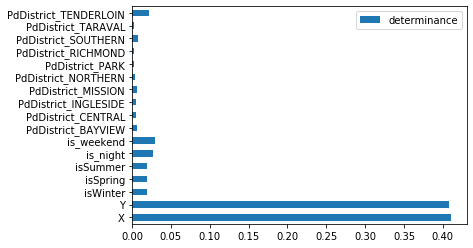

In [0]:
pd.DataFrame({"determinance":determinance}, index=list(X_train)).plot(kind="barh")

<h1>Experimenting with Different Models</h1>

Using pipelines to test other classifiers to see if they perform better


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    print("\nrunning new classifier")
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train.sample(n=10000), y_train.sample(n=10000))   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))


running new classifier
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.102

running new classifier
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
model score: 0.199

running new classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
model score: 0.101

running new classifier
RandomForest

In [0]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [0]:
from sklearn.metrics import accuracy_score
accuracy = model.score(X_test, y_test)
accuracy

0.22043543458041492

<h1>Pipeline Test Results</h1>
The pipeline test produced models more accurate than random forrest with subset data. However, the code demonstrated above shows that, when trained with the whole set, random forrest outperforms. Therefore, Random Forrest will be our choice for prediction.

<h1>The Final Prediction</h1>

In [0]:
test_raw = pd.read_csv("drive/Shared drives/SI370_KaggleDrive/assets/test.csv")
test_output = test_raw.copy()

In [0]:
test_model = prepare_data(test_raw)

In [0]:
predicted_labels = better_rf_model.predict(test_model)

In [0]:
test_output['category_pred'] = predicted_labels
test_output.sample(10)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,category_pred
333971,333971,2010-09-27 07:00:00,Monday,TARAVAL,500 Block of HOLLOWAY AV,-122.458703,37.721784,MISSING PERSON
203063,203063,2012-09-11 00:01:00,Tuesday,SOUTHERN,200 Block of HARRISON ST,-122.390709,37.787749,LARCENY/THEFT
395042,395042,2009-11-02 09:30:00,Monday,MISSION,900 Block of POTRERO AV,-122.406605,37.757158,MISSING PERSON
72153,72153,2014-06-03 22:30:00,Tuesday,BAYVIEW,1800 Block of 25TH ST,-122.397497,37.752307,ASSAULT
747179,747179,2004-10-24 10:00:00,Sunday,RICHMOND,1700 Block of BRODERICK ST,-122.441754,37.786452,LARCENY/THEFT
730078,730078,2005-01-18 22:14:00,Tuesday,BAYVIEW,700 Block of AMADOR ST,-122.386176,37.745805,OTHER OFFENSES
277992,277992,2011-07-24 10:30:00,Sunday,TARAVAL,19TH AV / LAWTON ST,-122.476685,37.757968,OTHER OFFENSES
162723,162723,2013-03-27 13:45:00,Wednesday,TENDERLOIN,300 Block of EDDY ST,-122.412931,37.783834,NON-CRIMINAL
138158,138158,2013-07-20 22:15:00,Saturday,NORTHERN,POST ST / FRANKLIN ST,-122.423218,37.786402,LARCENY/THEFT
165414,165414,2013-03-13 23:05:00,Wednesday,PARK,SCOTT ST / EDDY ST,-122.437263,37.780802,OTHER OFFENSES


<h1>Classification Struggles & Limitations</h1>
Classification difficulties include mostly runtime restrictions. 
While we received promising results using a pipeline to test different models on samples of the datasets, it became apparent that time constraints would create a significant barrier to realistically being able to use these models for such a large dataset. Attempting to use Gradient, for example, resulted in observing runtimes exceeding thirty minutes with no completion.

Grid Searching for ideal hyperparameters was deemed likewise unrealistic given the sheer size of the dataset. To circumvent this, we used samples to experiment with ideal hyperparameters and then tuned the model from there with estimation.

<h1>Classification Findings</h1>
Our classification findings show that time of day and time of year are significant indicators than police department/district for the determination of what categories of crime occur and when, but are not nearly as indicative as location.<br>
Keep in mind, this accuracy score is determined without weighing in any crime scene evidence at all.

<h1>Further Research Direction</h1>
Additional future research with additional metrics like "victim_is_female" or "blood_found" would likely ramp up the accuracy considerably. This model managed to predict crime category from nearly 40 possibilities more than 10x more accuratley than random selection. With actual crime evidence representation within our metrics, the algorithm would likely demonstrate better performance.

### Folium

Folium is a library that allows you to view lat/long points on a real map alongside additional data metrics. Here, we used Folium to plot crimes by area alongside their descriptions from our entire dataset and then with a subset of just substance related crimes.

In [0]:
# Uncomment the following line for folium import
##pip install folium

In [0]:
import folium
import pandas as pd 
import sys

from folium.plugins import MarkerCluster
from google.colab import drive

In [0]:
# Import data from Google Collab
drive.mount('/content/drive')

crimedata = pd.read_csv(
     'drive/Shared drives/SI370_KaggleDrive/assets/train.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Get a random sample of the data to prevent Jupyter kernel from crashing
sample = crimedata.sample(50000)

## General Crime Map
Map a sample of crime locations and display details.
<br />HTML map is created and saved in the same file folder as this script.

In [0]:
sf_boundary_coords = (37.76, -122.45)

In [0]:
# Create an empty map of San Francisco
map1 = folium.Map(location=sf_boundary_coords, zoom_start=12)

In [0]:
# Create location markers
mc = MarkerCluster().add_to(map1)

# Add crime data to the location markers
for each in sample.iterrows():
    folium.Marker(
        [each[1]['Y'], each[1]['X']],
        popup="S.F.P.D. District: {}".format(each[1]['PdDistrict'].lower().capitalize()) 
        + "<br><br>Crime Category: {}".format(each[1]['Category'].lower().capitalize())
        + "<br><br>Description: {}".format(each[1]['Descript'].lower().capitalize())
    ).add_to(mc)

In [0]:
# Run this cell to save the HTML map to prevent Jupyter kernel from crashing
# View it by opening it from the local project folder
mc.save('all_crimes_map.html')

## Crime-Specific Map
Map drug & alcohol crime locations occurring on weekends and display details.
<br />HTML map is created and saved in the same file folder as this script.

In [0]:
weekend_days = ['Sunday','Saturday']
substance_crimes = [
    'DRUNKENNESS',
    'DRUG/NARCOTIC',
    'DRIVING UNDER THE INFLUENCE'
] 

In [0]:
days_cond = crimedata['DayOfWeek'].isin(weekend_days) 
crimes_cond = crimedata['Category'].isin(substance_crimes)
 
filtered_crimeData = crimedata[days_cond & crimes_cond]

In [0]:
# Create an empty map of San Francisco
map2 = folium.Map(location=sf_boundary_coords, zoom_start=12)

In [0]:
# Create location markers
mc2 = MarkerCluster().add_to(map2)

# Add crime data to the location markers
for each in filtered_crimeData.iterrows():
    folium.Marker(
        [each[1]['Y'], each[1]['X']],
        popup="S.F.P.D. District: {}".format(each[1]['PdDistrict'].lower().capitalize()) 
        + "<br><br>Crime Category: {}".format(each[1]['Category'].lower().capitalize())
        + "<br><br>Description: {}".format(each[1]['Descript'].lower().capitalize())
    ).add_to(mc2)

In [0]:
# Run this cell to save the HTML map to prevent Jupyter kernel from crashing
# View it by opening it from the local project folder
mc2.save('wild_weekends_map.html')

### Visualization Findings

Folium allows us to visualize specific types of crime on specific days. Here, we wanted to observe how drugs and alchohol related crime affects different areas of the city during weekends, when usage rates are the highest. According to the "Wild Weekends" map, Metropolitan San Francisco, especially the O'Farrell Street area, sees more than 300% more drug and alchohol related crime on the weekends than the next highest area. Additionally, there appears to be a massive drug hotspot at the intersection of Ellis and Jones Street. 

### Challenges & Limitations

The dataset used to produce these visualizations is very large. This made preparing and working with the data complicated. We chose to work with a random sample of 50,000 records after trial and error, simply attempting to take larger samples until our kernels died. 

The visualization is saved to a file rather than displayed in Jupyter. This is also a result of the size of the dataset. While we were determining an appropriate sample size, we noticed that as the samples grew larger the maps would no longer render. Saving the maps to HTML files and accessing the visualization by opening them in the project folder allowed us to include a much larger portion of the dataset.

### Future Work

We wanted to plot as many data points on the map as possible. Although we were able to include a large sample of the data, we would like to explore additional or alternative tools that could allow us to map the entire dataset. 

This dataset includes a wide variety of reported crimes and metadata not reflected or easily unnoticed in the current visualizations. Future considerations include user-defined map options, such as specific crime categories or timespan. 
